In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(11)

column_names = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'grade_of_spondylolisthesis', 'class']
df = pd.read_csv('vertebral column data.txt', sep = ' ', names=column_names)
print(df.head())
print(df.tail())
print(df.info())
print(df.describe())
print(df['class'].value_counts())

   pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0             63.03        22.55                  39.61         40.48   
1             39.06        10.06                  25.02         29.00   
2             68.83        22.22                  50.09         46.61   
3             69.30        24.65                  44.31         44.64   
4             49.71         9.65                  28.32         40.06   

   pelvic_radius  grade_of_spondylolisthesis class  
0          98.67                       -0.25    AB  
1         114.41                        4.56    AB  
2         105.99                       -3.53    AB  
3         101.87                       11.21    AB  
4         108.17                        7.92    AB  
     pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
305             47.90        13.62                  36.00         34.29   
306             53.94        20.72                  29.22         33.22   
307             61

### Some boxplots for univariate EDA

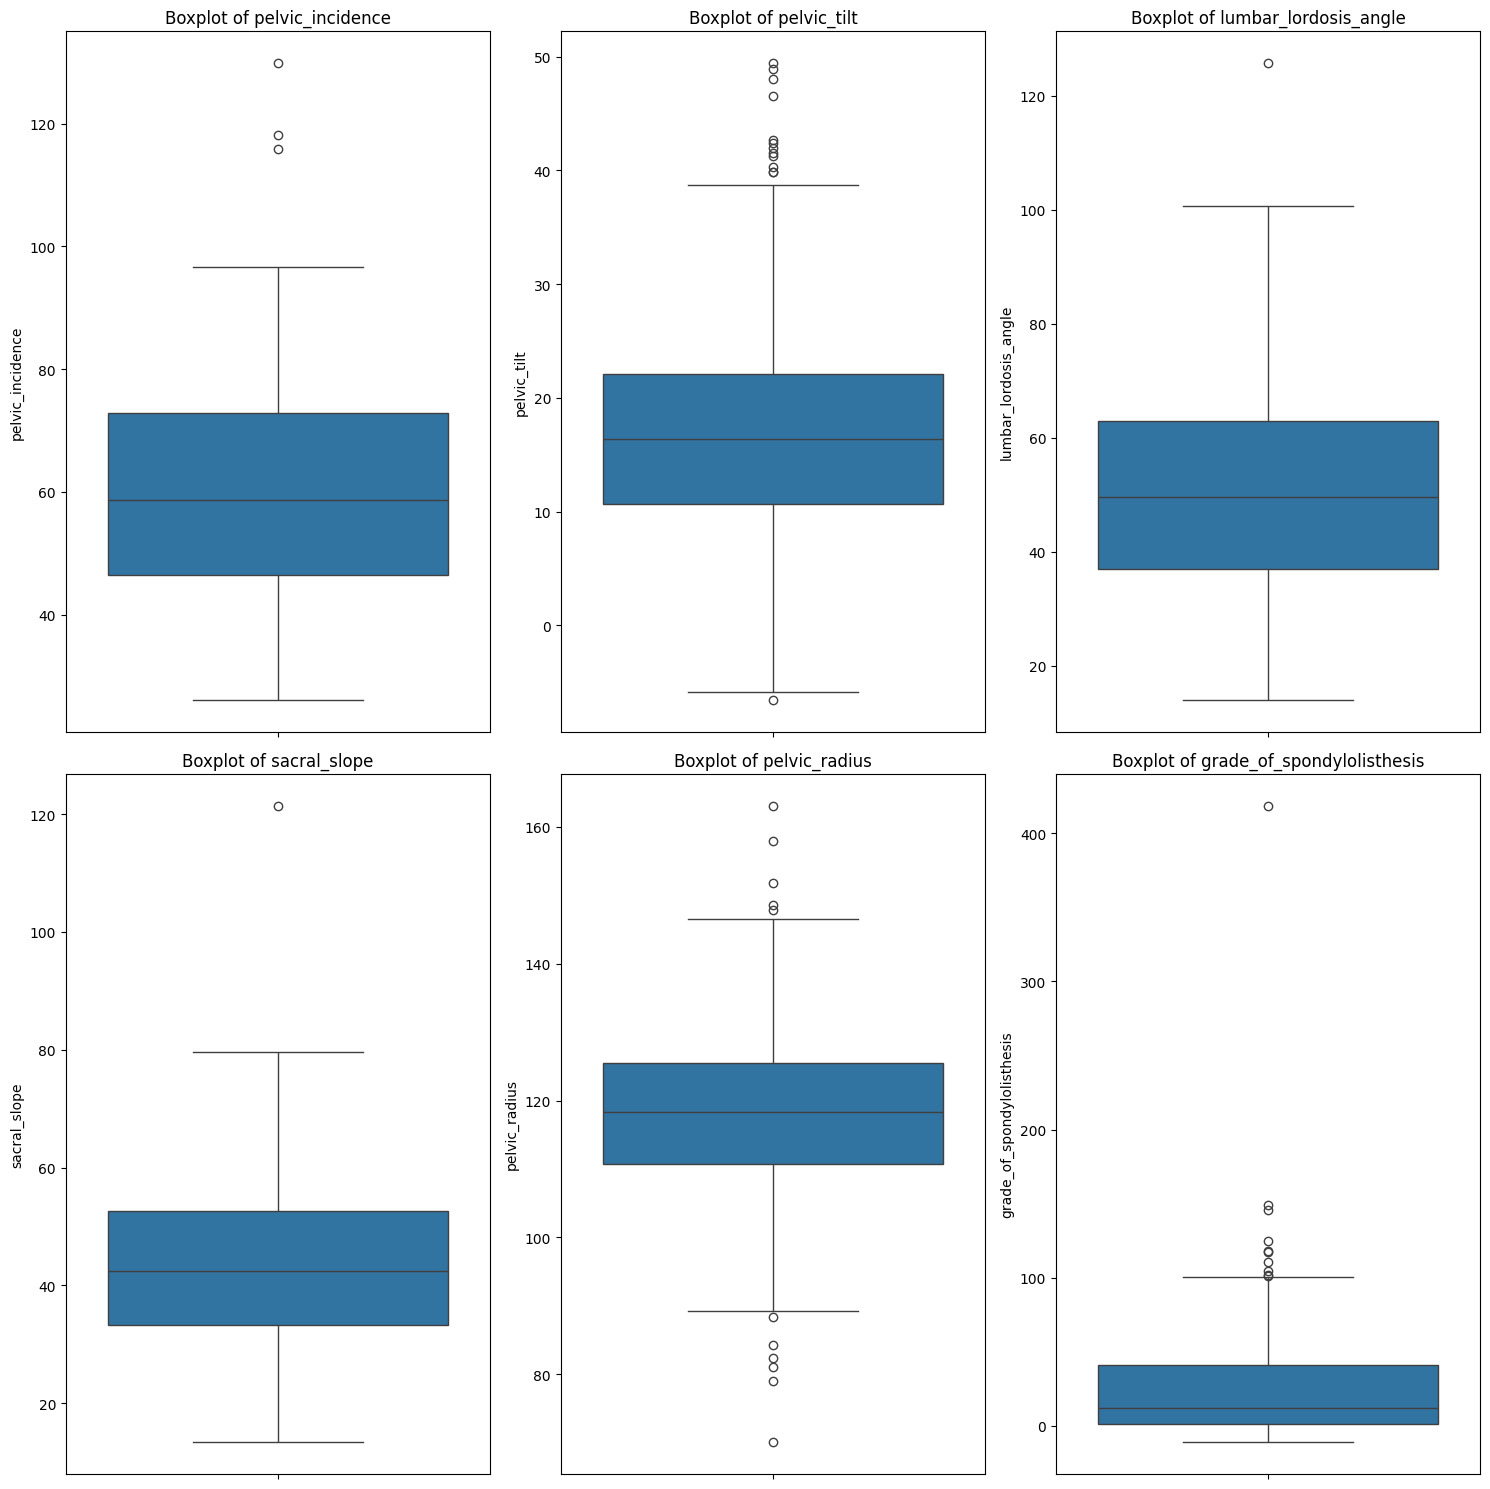

In [17]:
fig, axes = plt.subplots(2, 3, figsize = (15, 15)) 
axes = axes.flatten() 

for i, column in enumerate(df.columns[:-1]): 
    sns.boxplot(ax = axes[i], y = column, data = df)
    axes[i].set_title(f'Boxplot of {column}')

plt.tight_layout() 
plt.show()

### Now let's plot them by class (Abnormal or Normal)

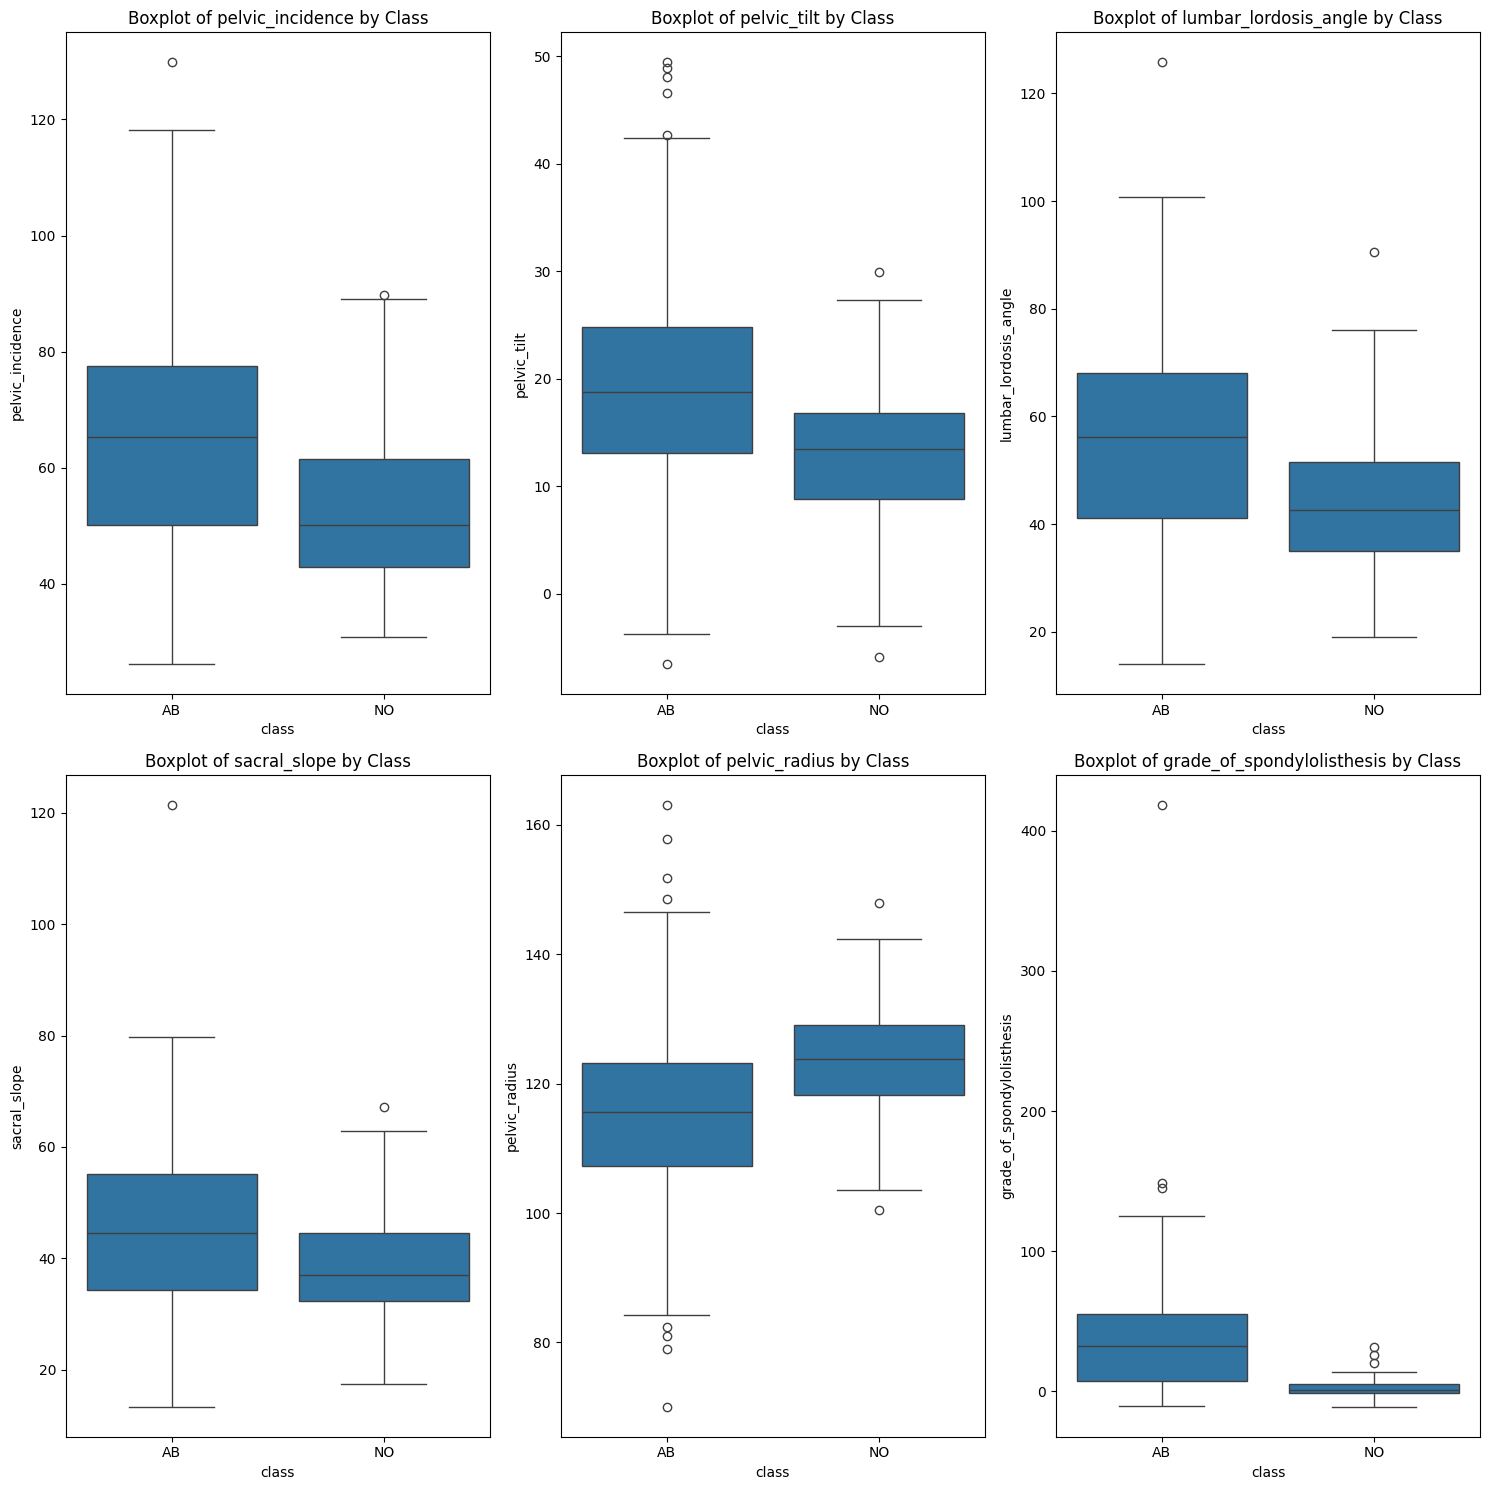

In [18]:
fig, axes = plt.subplots(2, 3, figsize = (15, 15)) 
axes = axes.flatten() 

for i, column in enumerate(df.columns[:-1]): 
    sns.boxplot(ax = axes[i], x = 'class', y = column, data = df)
    axes[i].set_title(f'Boxplot of {column} by Class')

plt.tight_layout() 
plt.show()

### Most data points, including outliers, seem possible, but the one data point (with grade_of_spondylolisthesis of 418.54) may be the result of an error.  

In [19]:
max_sacral_slope_row = df.loc[df['sacral_slope'].idxmax()]
print(max_sacral_slope_row)

# This data point is also responsible for other outlier values (in other features), so let's remove it
df = df.drop(df['sacral_slope'].idxmax())
df.info()

pelvic_incidence              129.83
pelvic_tilt                      8.4
lumbar_lordosis_angle          48.38
sacral_slope                  121.43
pelvic_radius                 107.69
grade_of_spondylolisthesis    418.54
class                             AB
Name: 115, dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 309 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   pelvic_incidence            309 non-null    float64
 1   pelvic_tilt                 309 non-null    float64
 2   lumbar_lordosis_angle       309 non-null    float64
 3   sacral_slope                309 non-null    float64
 4   pelvic_radius               309 non-null    float64
 5   grade_of_spondylolisthesis  309 non-null    float64
 6   class                       309 non-null    object 
dtypes: float64(6), object(1)
memory usage: 19.3+ KB


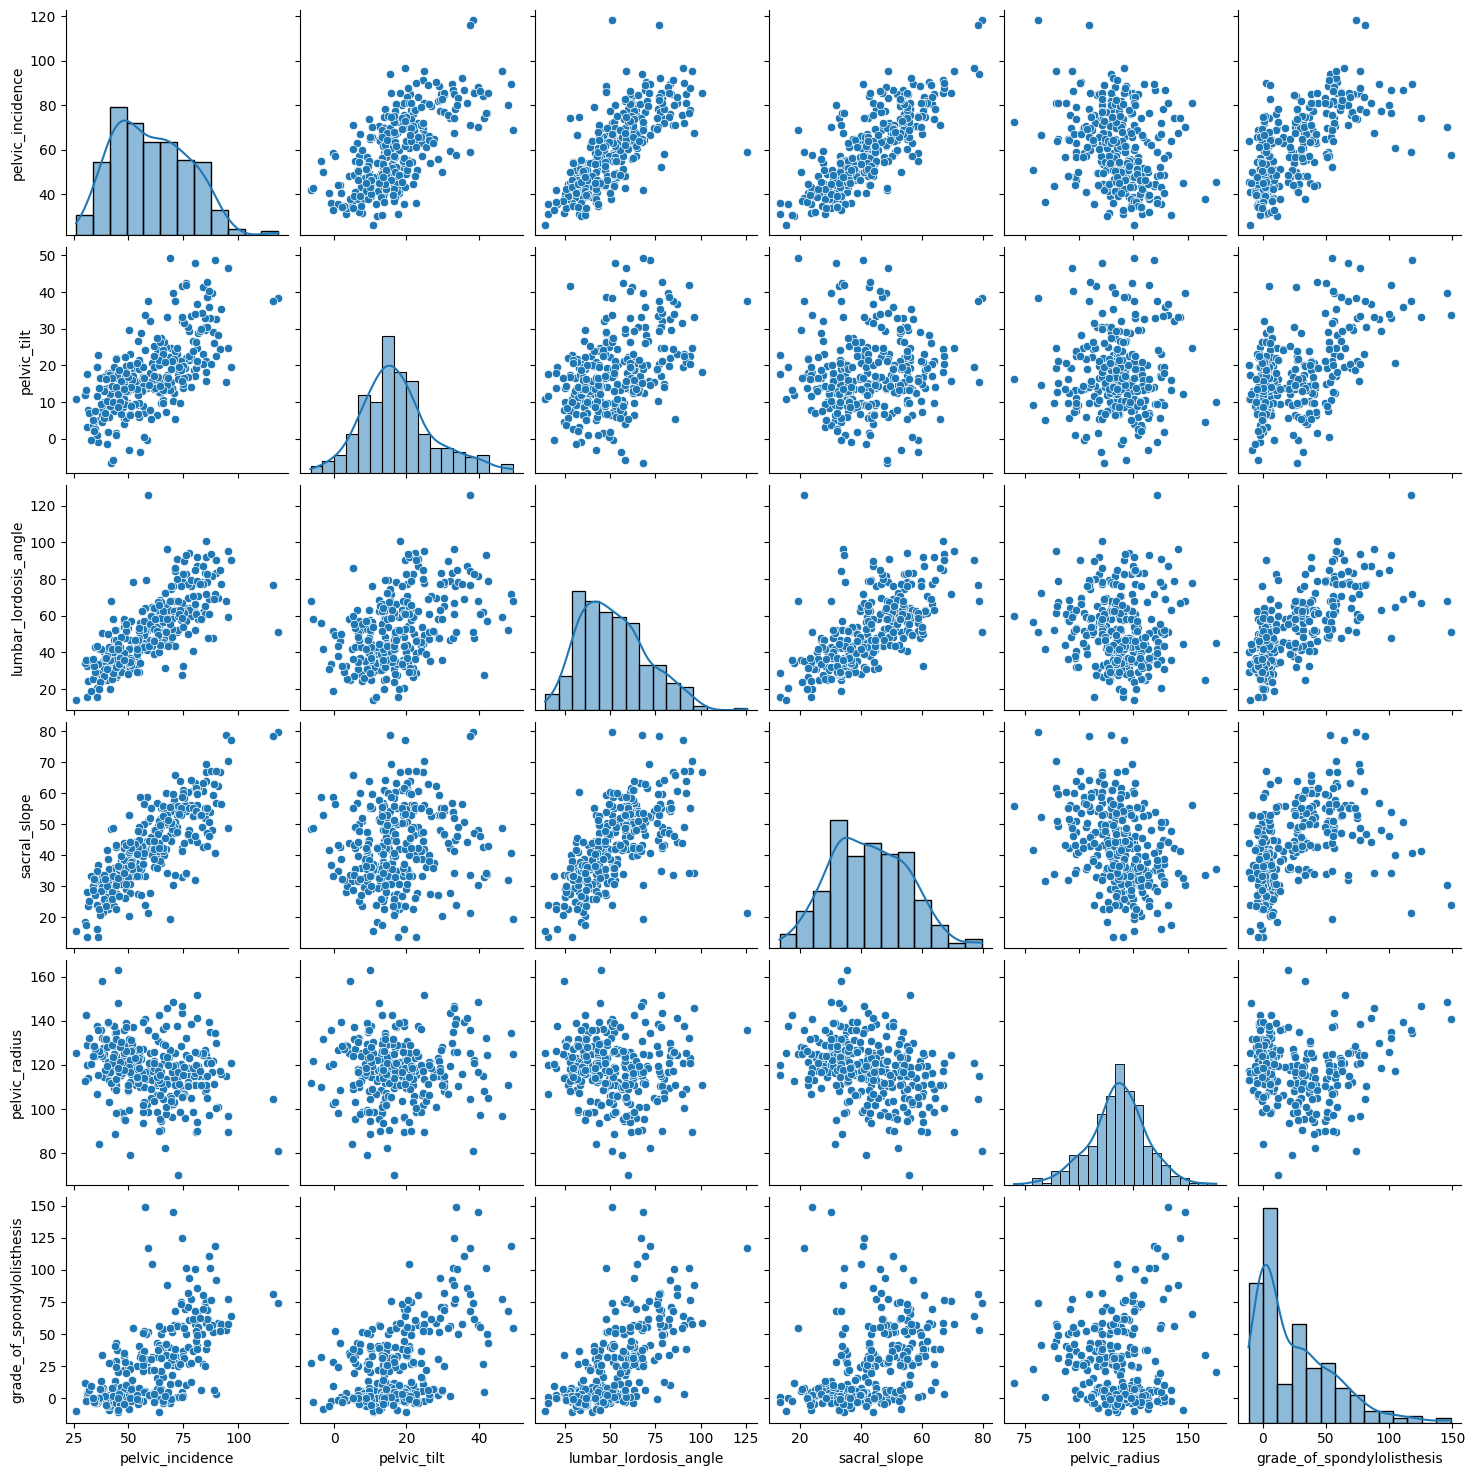

In [20]:
# Pairplots
sns.pairplot(df, diag_kind='hist', diag_kws={'kde':True})
plt.show()

### grade_of_spondylolisthesis looks very skewed. Let's do something about it.

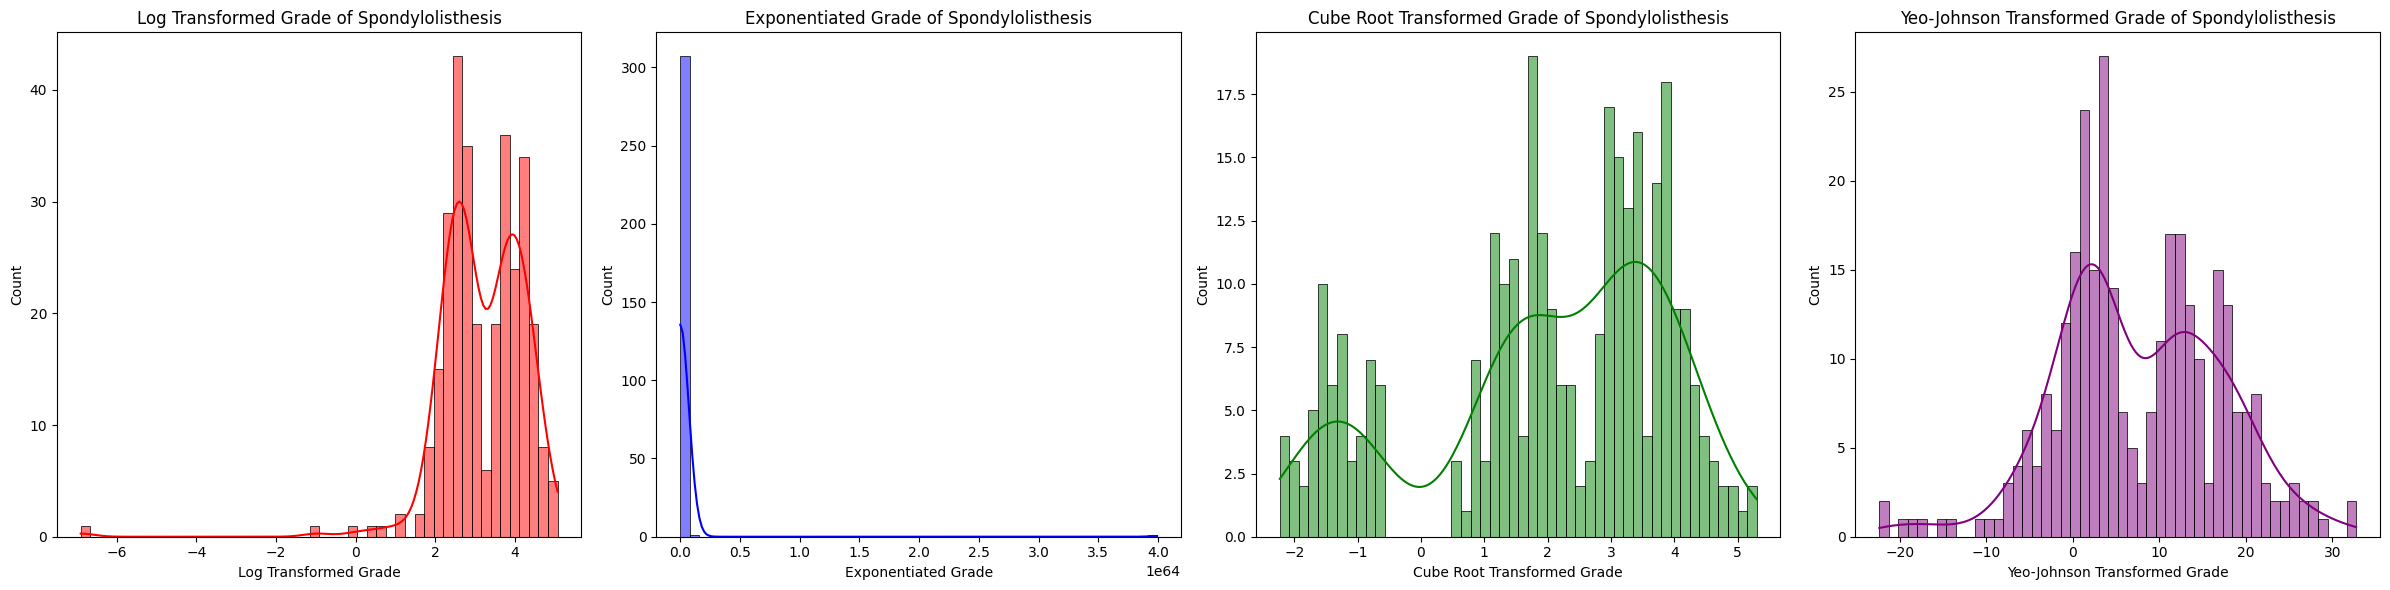

After the transformation:


In [21]:
# Try log transformation (avoid negative values)
df['log_transformed_grade'] = np.log(df['grade_of_spondylolisthesis'] + abs(df['grade_of_spondylolisthesis'].min()) + 0.001)
# Try exponentiation
df['exp_transformed_grade'] = np.exp(df['grade_of_spondylolisthesis'])
# Cube root transform the variable
df['cbrt_transformed_grade'] = np.cbrt(df['grade_of_spondylolisthesis'])
from scipy.stats import yeojohnson
df['yeo_johnson_transformed_grade'] = yeojohnson(df['grade_of_spondylolisthesis'])[0]


# Plot histograms side by side for each transformation
fig, axes = plt.subplots(1, 4, figsize = (24, 6))

# Log Transformation Histogram
sns.histplot(df['log_transformed_grade'], bins = 50, kde = True, color = 'red', ax = axes[0])
axes[0].set_title('Log Transformed Grade of Spondylolisthesis')
axes[0].set_xlabel('Log Transformed Grade')

# Exponentiation Histogram
sns.histplot(df['exp_transformed_grade'], bins = 50, kde = True, color = 'blue', ax = axes[1])
axes[1].set_title('Exponentiated Grade of Spondylolisthesis')
axes[1].set_xlabel('Exponentiated Grade')

# Cube Root Transformation Histogram
sns.histplot(df['cbrt_transformed_grade'], bins = 50, kde = True, color = 'green', ax = axes[2])
axes[2].set_title('Cube Root Transformed Grade of Spondylolisthesis')
axes[2].set_xlabel('Cube Root Transformed Grade')

# Yeo-Johnson Transformation Histogram
sns.histplot(df['yeo_johnson_transformed_grade'], bins = 50, kde = True, color = 'purple', ax = axes[3])
axes[3].set_title('Yeo-Johnson Transformed Grade of Spondylolisthesis')
axes[3].set_xlabel('Yeo-Johnson Transformed Grade')

plt.tight_layout()
plt.show()

# Let's only keep the Yeo Johnson Transformation (worked slightly better than cube root later in the PCA stage- code has been omitted)
df.drop(['exp_transformed_grade', 'log_transformed_grade', 'cbrt_transformed_grade', 'grade_of_spondylolisthesis'], axis = 1, inplace = True)
print("After the transformation:")


### Standardise the data to prepare for PCA

In [22]:
from sklearn.preprocessing import StandardScaler
df_2 = df.drop('class', axis = 1)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_2)
df_2_scaled = pd.DataFrame(data_scaled, columns = df_2.columns)

# Make sure the rows match when we concatenate
df_2_scaled.set_index(df_2.index, inplace=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Add 'class' back
df_scaled_with_class = pd.concat([df_2_scaled, df['class']], axis = 1)

### PCA

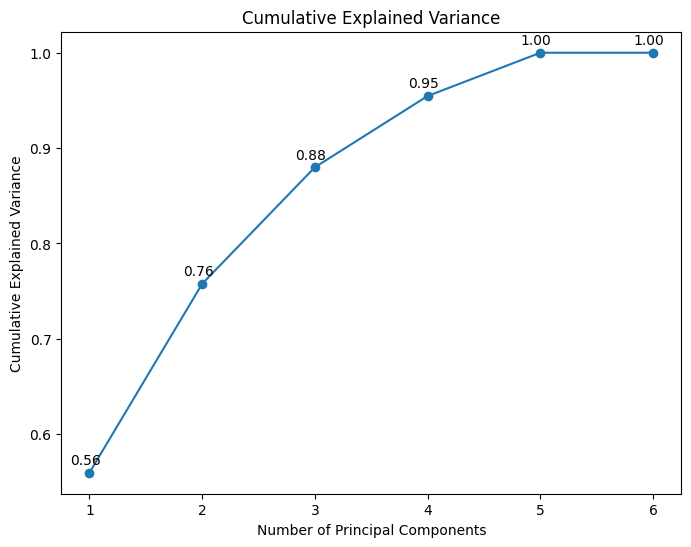

In [23]:
from sklearn.decomposition import PCA
pca = PCA()
pca_data = pca.fit_transform(df_2_scaled)

# Plot the cumulative explained variance
plt.figure(figsize = (8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker = 'o')

for i, (x, y) in enumerate(zip(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))):
    plt.annotate(f'{y:.2f}', (x, y), textcoords = "offset points", xytext = (-3, 6), ha = 'center')

plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


### Let's plot the PCA graph for PC1 and PC2

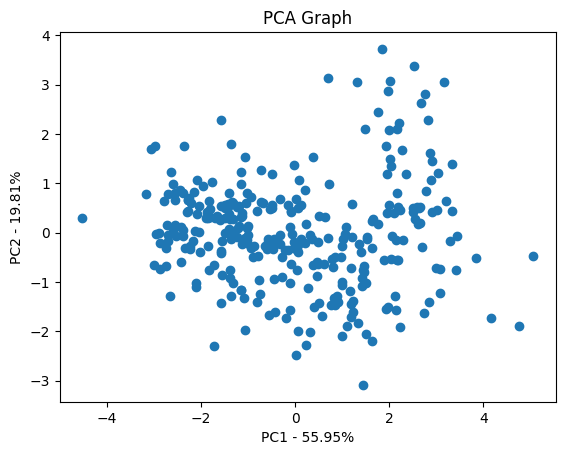

In [24]:
from sklearn.preprocessing import LabelEncoder
pca_df = pd.DataFrame(pca_data, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('PCA Graph')
# Display the percentage of variance explained by each PC on the two axes
plt.xlabel('PC1 - {0:.2f}%'.format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel('PC2 - {0:.2f}%'.format(pca.explained_variance_ratio_[1] * 100))

# Add 'class' back
pca_df.index = df_scaled_with_class.index
pca_df_with_class = pd.concat([pca_df, df_scaled_with_class['class']], axis = 1)

### We know that there are two (or three) classes, but let's try an elbow plot anyway to confirm

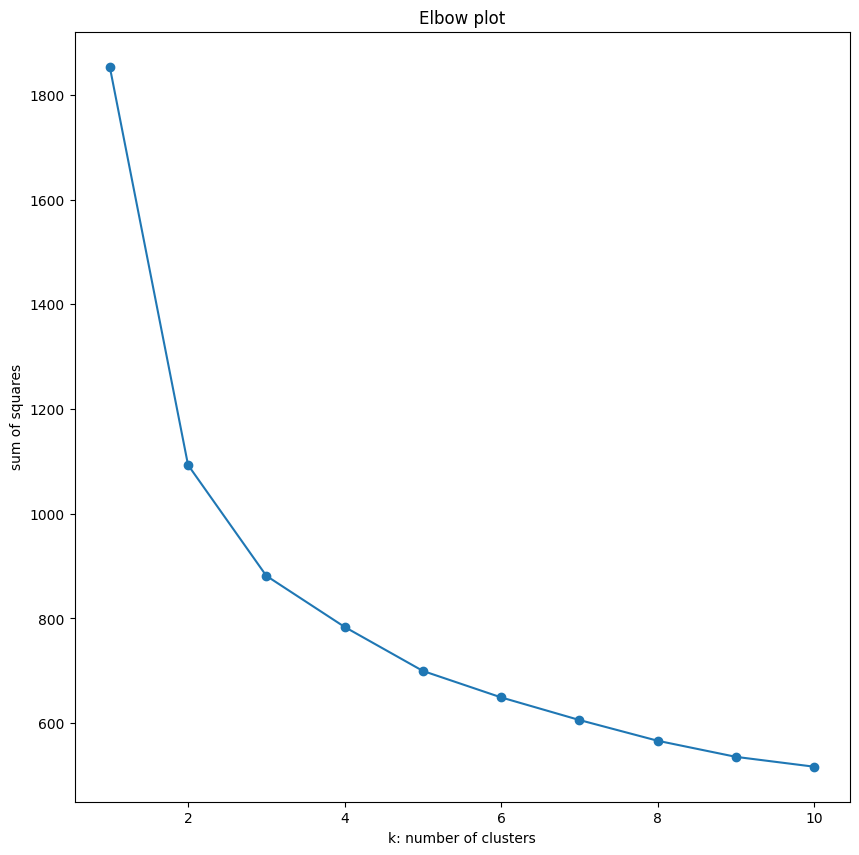

In [25]:
from sklearn.cluster import KMeans
k_min = 1
k_max = 10
reps = 10
k_values = np.zeros(k_max - k_min + 1)
sumOfSquares = np.zeros(k_max - k_min + 1)
for k in range(k_min, k_max + 1):
	k_values[k - k_min] = k
	kmeansResult = KMeans(k, n_init = reps).fit(pca_df)
	sumOfSquares[k - k_min] = kmeansResult.inertia_
	
#elbow plot
plt.figure(figsize = [10,10])
plt.plot(k_values, sumOfSquares)
plt.scatter(x = k_values, y = sumOfSquares)
plt.title('Elbow plot')
plt.xlabel('k: number of clusters')
plt.ylabel('sum of squares')
plt.show()

### It seems 2, 3, 4, or even 5 clusters could be a good choice here according to the elbow plot. Even though we know there are 2 distinct classes/clusters, let's try 3,4, and 5 clusters as well.
### K-Means Clustering

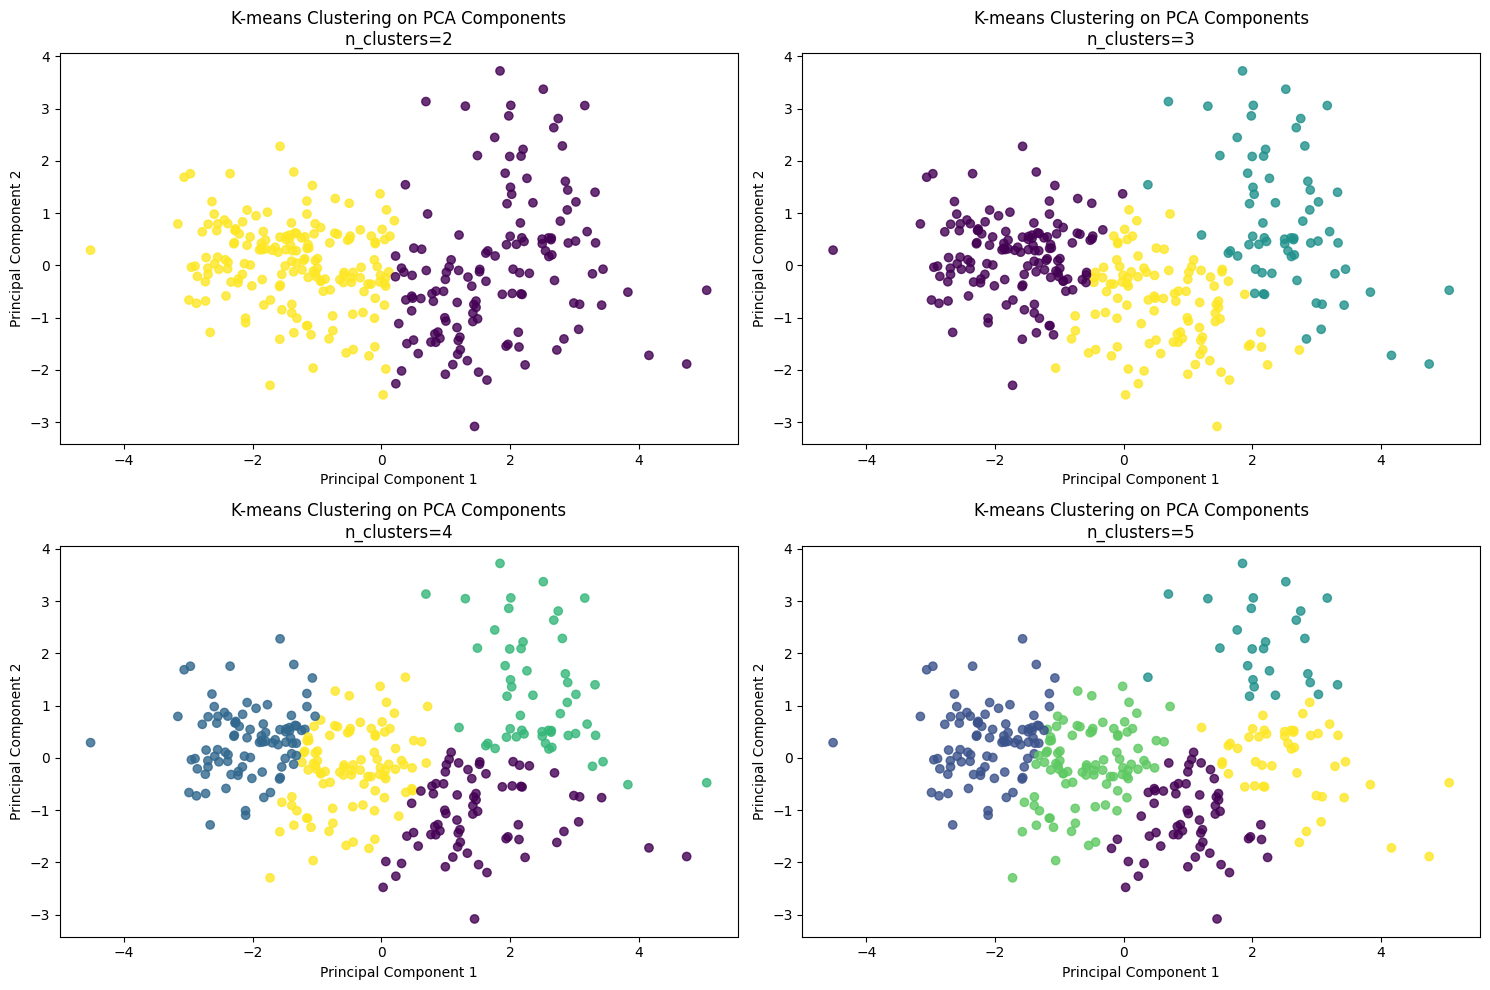

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

n_clusters_options = [2, 3, 4, 5]
for i, n_clusters in enumerate(n_clusters_options):
    row = i // 2
    col = i % 2
    kmeans = KMeans(n_clusters = n_clusters, n_init = 10)
    pca_df['cluster'] = kmeans.fit_predict(pca_df[['PC1', 'PC2']])
    axs[row, col].scatter(pca_df['PC1'], pca_df['PC2'], c = pca_df['cluster'], cmap = 'viridis', alpha = 0.8)
    axs[row, col].set_title(f'K-means Clustering on PCA Components\nn_clusters={n_clusters}')
    axs[row, col].set_xlabel('Principal Component 1')
    axs[row, col].set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

### Supervised
### Since we plan on splitting into train-test, we need to split before standardising and conducting PCA to prevent data leakage.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# train and test sets
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 11, stratify = df['class'])

# Balancing the training dataset
class_ab = df_train[df_train['class'] == 'AB']
class_no = df_train[df_train['class'] == 'NO']
class_ab_undersampled = class_ab.sample(len(class_no), random_state = 11)
df_train_balanced = pd.concat([class_ab_undersampled, class_no]).sample(frac = 1, random_state = 11).reset_index(drop = True)

X_train = df_train_balanced.drop('class', axis = 1)
y_train = df_train_balanced['class']
X_test = df_test.drop('class', axis = 1)
y_test = df_test['class']

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying PCA
pca = PCA()
pca_data_train = pca.fit_transform(X_train_scaled)
pca_data_test = pca.transform(X_test_scaled)

### We will try three different models and use three different sets of inputs.

In [28]:
classifiers = {
    "SVM": SVC(kernel = 'rbf', random_state = 11),
    "RandomForest": RandomForestClassifier(random_state = 11, max_depth = 2),
    "KNeighbors": KNeighborsClassifier()
}

input_sets = {
    'PC1-PC2': (pca_data_train[:, :2], pca_data_test[:, :2]),
    'PC1-PC6': (pca_data_train[:, :6], pca_data_test[:, :6]),
    'Scaled Data': (X_train_scaled, X_test_scaled)
    }

### We can evaluate the performance of each model on each set of inputs. In the scenario in which we only use PC1 and PC2 as inputs, we can also visualise the decision boundaries of each model.

Shapes - X_train: (160, 2), y_train: (160,), X_val: (62, 2), y_val: (62,)
---SVM with PC1-PC2 on Training Data---
Confusion Matrix:
 [[57 23]
 [11 69]]
Classification Report:
               precision    recall  f1-score   support

          AB       0.84      0.71      0.77        80
          NO       0.75      0.86      0.80        80

    accuracy                           0.79       160
   macro avg       0.79      0.79      0.79       160
weighted avg       0.79      0.79      0.79       160

---SVM with PC1-PC2 on Validation Data---
Confusion Matrix:
 [[33  9]
 [ 7 13]]
Classification Report:
               precision    recall  f1-score   support

          AB       0.82      0.79      0.80        42
          NO       0.59      0.65      0.62        20

    accuracy                           0.74        62
   macro avg       0.71      0.72      0.71        62
weighted avg       0.75      0.74      0.74        62





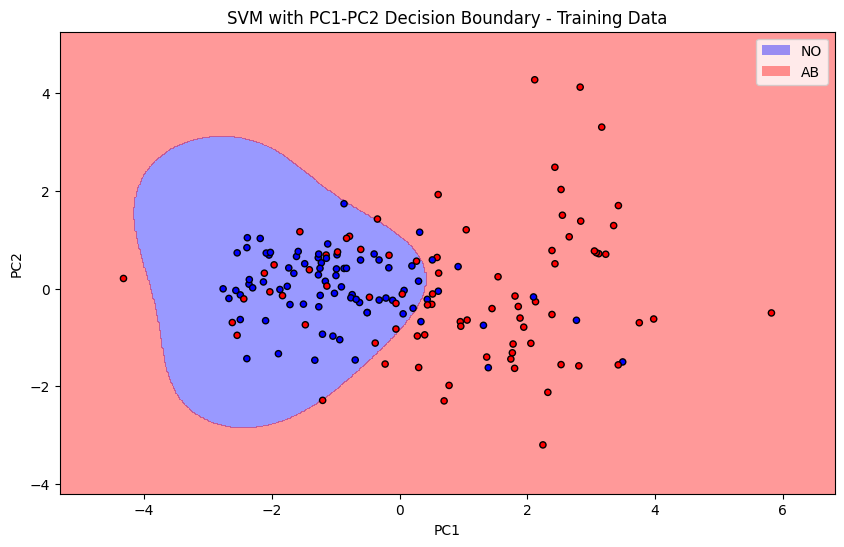

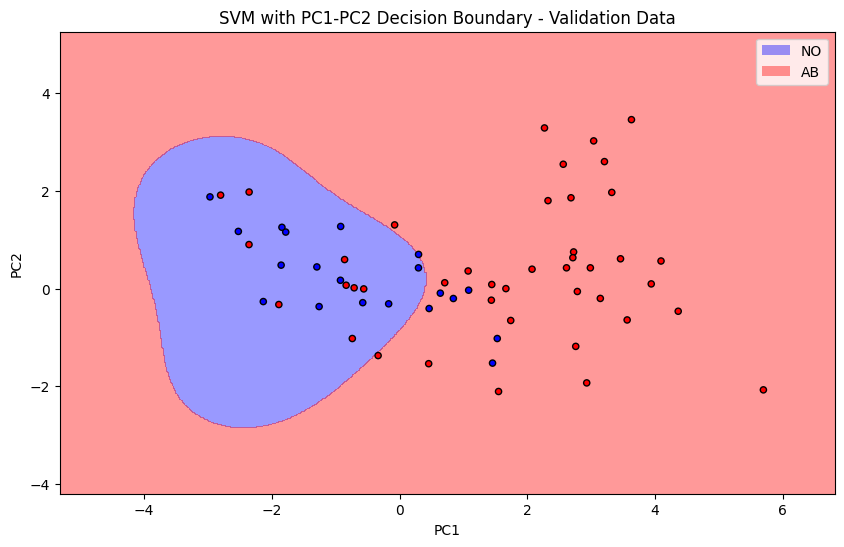

Shapes - X_train: (160, 6), y_train: (160,), X_val: (62, 6), y_val: (62,)
---SVM with PC1-PC6 on Training Data---
Confusion Matrix:
 [[66 14]
 [ 6 74]]
Classification Report:
               precision    recall  f1-score   support

          AB       0.92      0.82      0.87        80
          NO       0.84      0.93      0.88        80

    accuracy                           0.88       160
   macro avg       0.88      0.88      0.87       160
weighted avg       0.88      0.88      0.87       160

---SVM with PC1-PC6 on Validation Data---
Confusion Matrix:
 [[40  2]
 [ 4 16]]
Classification Report:
               precision    recall  f1-score   support

          AB       0.91      0.95      0.93        42
          NO       0.89      0.80      0.84        20

    accuracy                           0.90        62
   macro avg       0.90      0.88      0.89        62
weighted avg       0.90      0.90      0.90        62



Shapes - X_train: (160, 6), y_train: (160,), X_val: (62, 6), y_v

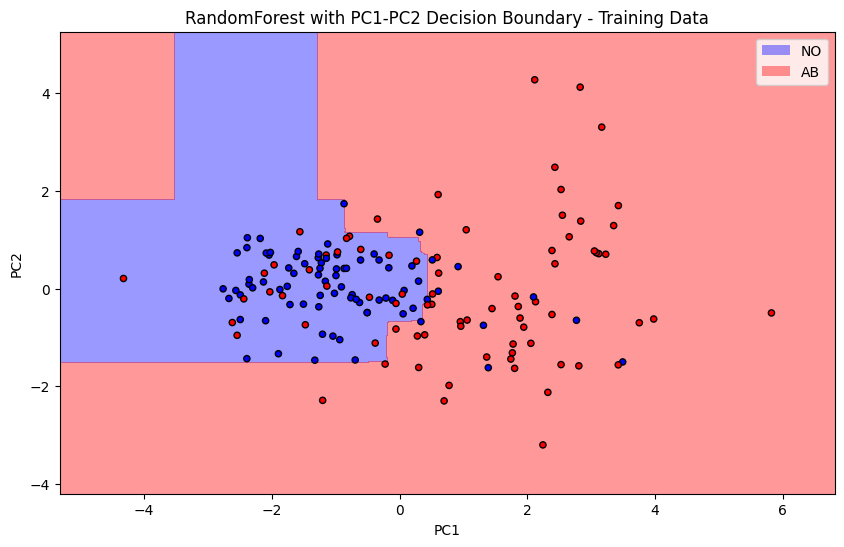

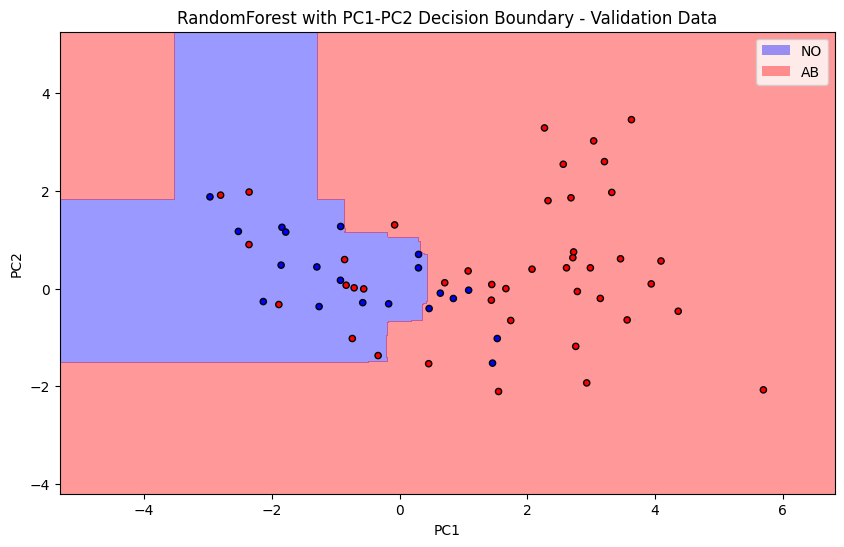

Shapes - X_train: (160, 6), y_train: (160,), X_val: (62, 6), y_val: (62,)
---RandomForest with PC1-PC6 on Training Data---
Confusion Matrix:
 [[65 15]
 [ 6 74]]
Classification Report:
               precision    recall  f1-score   support

          AB       0.92      0.81      0.86        80
          NO       0.83      0.93      0.88        80

    accuracy                           0.87       160
   macro avg       0.87      0.87      0.87       160
weighted avg       0.87      0.87      0.87       160

---RandomForest with PC1-PC6 on Validation Data---
Confusion Matrix:
 [[35  7]
 [ 6 14]]
Classification Report:
               precision    recall  f1-score   support

          AB       0.85      0.83      0.84        42
          NO       0.67      0.70      0.68        20

    accuracy                           0.79        62
   macro avg       0.76      0.77      0.76        62
weighted avg       0.79      0.79      0.79        62



Shapes - X_train: (160, 6), y_train: (160,), X

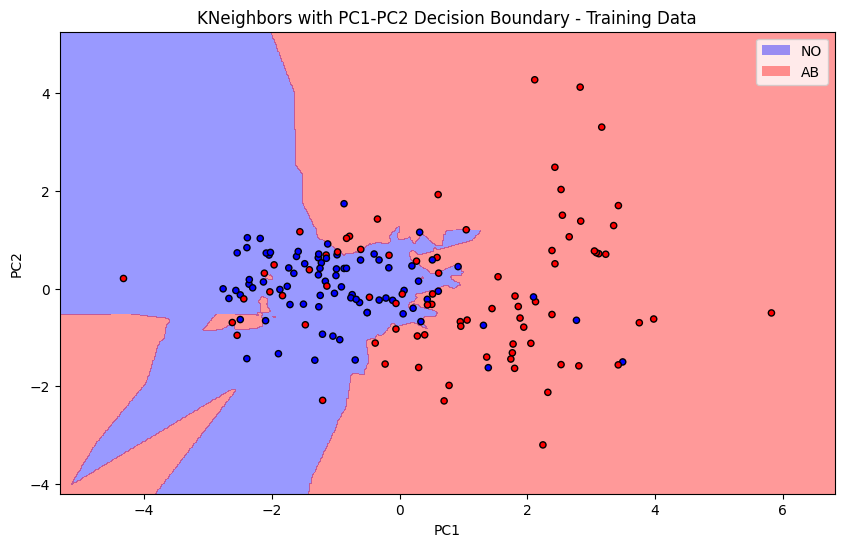

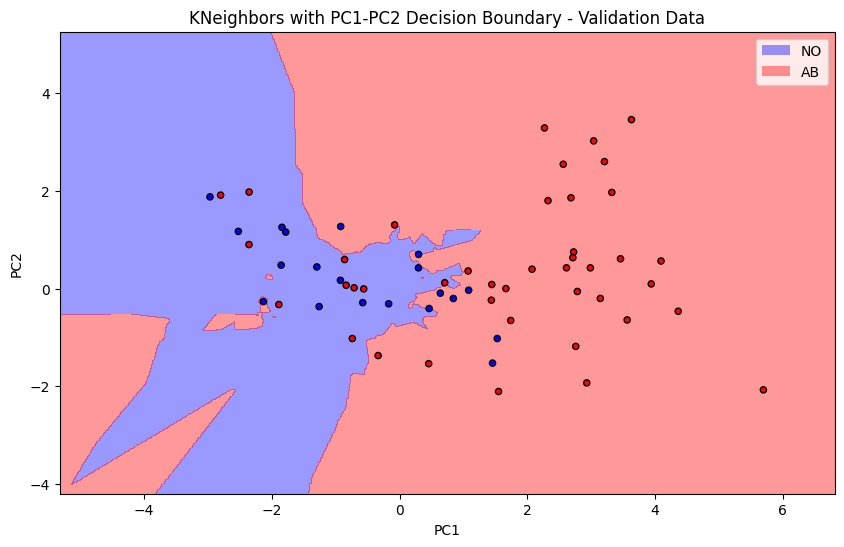

Shapes - X_train: (160, 6), y_train: (160,), X_val: (62, 6), y_val: (62,)
---KNeighbors with PC1-PC6 on Training Data---
Confusion Matrix:
 [[64 16]
 [ 7 73]]
Classification Report:
               precision    recall  f1-score   support

          AB       0.90      0.80      0.85        80
          NO       0.82      0.91      0.86        80

    accuracy                           0.86       160
   macro avg       0.86      0.86      0.86       160
weighted avg       0.86      0.86      0.86       160

---KNeighbors with PC1-PC6 on Validation Data---
Confusion Matrix:
 [[37  5]
 [ 5 15]]
Classification Report:
               precision    recall  f1-score   support

          AB       0.88      0.88      0.88        42
          NO       0.75      0.75      0.75        20

    accuracy                           0.84        62
   macro avg       0.82      0.82      0.82        62
weighted avg       0.84      0.84      0.84        62



Shapes - X_train: (160, 6), y_train: (160,), X_val

In [29]:
def plot_decision_boundary(X_train, y_train, X_val, y_val, model, title):
    x_min, x_max = min(X_train[:, 0].min(), X_val[:, 0].min()) - 1, max(X_train[:, 0].max(), X_val[:, 0].max()) + 1
    y_min, y_max = min(X_train[:, 1].min(), X_val[:, 1].min()) - 1, max(X_train[:, 1].max(), X_val[:, 1].max()) + 1
    h = 0.02

    # Generate a mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Prediction
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Convert string to numerical
    Z_numeric = np.where(Z == "AB", 1, 0)

    # Reshape Z_numeric for plotting
    Z_reshaped = Z_numeric.reshape(xx.shape)

    # Plotting for Training Data
    plt.figure(figsize = (10, 6))
    contour = plt.contourf(xx, yy, Z_reshaped, alpha = 0.4, levels = [-1, 0, 1], colors = ['blue', 'red'])
    colors_train = ['red' if label == "AB" else 'blue' for label in y_train]
    plt.scatter(X_train[:, 0], X_train[:, 1], c = colors_train, s = 20, edgecolor = 'k')
    plt.title(f'{title} - Training Data')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(handles = contour.legend_elements()[0], labels = ['NO', 'AB'])
    plt.show()

    # Plotting for Validation Data
    plt.figure(figsize = (10, 6))
    contour = plt.contourf(xx, yy, Z_reshaped, alpha = 0.4, levels = [-1, 0, 1], colors = ['blue', 'red'])
    colors_valid = ['red' if label == "AB" else 'blue' for label in y_val]
    plt.scatter(X_val[:, 0], X_val[:, 1], c = colors_valid, s = 20, edgecolor = 'k')
    plt.title(f'{title} - Validation Data')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(handles = contour.legend_elements()[0], labels = ['NO', 'AB'])
    plt.show()

# Include decision boundary plotting for PC1-PC2 case
def evaluate_model_split_with_boundary(model, X_train, y_train, X_val, y_val, model_name, data_name):
    print(f"Shapes - X_train: {X_train.shape}, y_train: {y_train.shape}, X_val: {X_val.shape}, y_val: {y_val.shape}")
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    print(f"---{model_name} on Training Data---")
    # Confusion Matrix for Training Data
    print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
    print("Classification Report:\n", classification_report(y_train, y_train_pred))
    print(f"---{model_name} on Validation Data---")
    # Confusion Matrix for Validation Data
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
    print("Classification Report:\n", classification_report(y_val, y_val_pred))
    print("\n")
    if data_name == 'PC1-PC2':
        plot_decision_boundary(X_train, y_train, X_val, y_val, model, f"{model_name} Decision Boundary")

# Training and evaluating models with boundary plotting for PC1-PC2 case
for name, clf in classifiers.items():
    for data_name, (X_train_set, X_test_set) in input_sets.items():
        evaluate_model_split_with_boundary(clf, X_train_set, y_train, X_test_set, y_test, f"{name} with {data_name}", data_name)